In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
train_files = [f'train_FD00{i}.txt' for i in range(1, 5)]
test_files = [f'test_FD00{i}.txt' for i in range(1, 5)]
rul_files = [f'RUL_FD00{i}.txt' for i in range(1, 5)]

In [3]:
def load_dataset(filename):
    return pd.read_csv( filename ,delim_whitespace=True, header=None)

train_dfs = [load_dataset(file) for file in train_files]
test_dfs = [load_dataset(file) for file in test_files]
rul_dfs = [load_dataset(file) for file in rul_files]

C:\Users\takhiuddin\AppData\Local\Temp\ipykernel_30100\26103341.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv( filename ,delim_whitespace=True, header=None)
C:\Users\takhiuddin\AppData\Local\Temp\ipykernel_30100\26103341.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv( filename ,delim_whitespace=True, header=None)
C:\Users\takhiuddin\AppData\Local\Temp\ipykernel_30100\26103341.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv( filename ,delim_whitespace=True, header=None)
C:\Users\takhiuddin\AppData\Local\Temp\ipykernel_30100\26103341.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be rem

In [4]:
column_names = ['unit_number', 'time_in_cycles', 'operational_setting_1', 'operational_setting_2',
                'operational_setting_3'] + [f'sensor_{i}' for i in range(6, 27)]

for df in train_dfs + test_dfs:
    df.columns = column_names

In [5]:
def calculate_rul(train_df, rul_df):
    rul_series = rul_df[0].values
    rul_df['unit_number'] = range(1, len(rul_df) + 1)  # To align with unit numbers
    for unit in train_df['unit_number'].unique():
        unit_cycles = train_df[train_df['unit_number'] == unit]['time_in_cycles'].max()
        rul = unit_cycles - train_df[train_df['unit_number'] == unit]['time_in_cycles'] 
        train_df.loc[train_df['unit_number'] == unit, 'RUL'] = rul
    
    return train_df

In [6]:
train_rul_dfs = [calculate_rul(train, rul) for train, rul in zip(train_dfs, rul_dfs)]


In [7]:
combined_train_dfs = [train.assign(RUL=train['RUL']) for train in train_rul_dfs]
def assign_rul_test(test_df, train_df):
    test_df['RUL'] = test_df['unit_number'].apply(lambda x: train_df[train_df['unit_number'] == x]['time_in_cycles'].max())
    test_df['RUL'] = test_df['RUL'] - test_df['time_in_cycles']
    return test_df

In [10]:
test_dfs_with_rul = [assign_rul_test(test, train) for test, train in zip(test_dfs, train_dfs)]

In [11]:
print(combined_train_dfs[0].head())
print(test_dfs_with_rul[0].head())

   unit_number  time_in_cycles  operational_setting_1  operational_setting_2  \
0            1               1                -0.0007                -0.0004   
1            1               2                 0.0019                -0.0003   
2            1               3                -0.0043                 0.0003   
3            1               4                 0.0007                 0.0000   
4            1               5                -0.0019                -0.0002   

   operational_setting_3  sensor_6  sensor_7  sensor_8  sensor_9  sensor_10  \
0                  100.0    518.67    641.82   1589.70   1400.60      14.62   
1                  100.0    518.67    642.15   1591.82   1403.14      14.62   
2                  100.0    518.67    642.35   1587.99   1404.20      14.62   
3                  100.0    518.67    642.35   1582.79   1401.87      14.62   
4                  100.0    518.67    642.37   1582.85   1406.22      14.62   

   ...  sensor_18  sensor_19  sensor_20  sen

In [13]:
def create_features(df):
    # Calculate statistical features for sensors
    for i in range(6, 27):
        df[f'sensor_{i}_mean'] = df[f'sensor_{i}'].rolling(window=5).mean()
        df[f'sensor_{i}_std'] = df[f'sensor_{i}'].rolling(window=5).std()
        df[f'sensor_{i}_max'] = df[f'sensor_{i}'].rolling(window=5).max()
    
    # Create lag features (example for the last 2 time steps)
    for i in range(6, 27):
        df[f'sensor_{i}_lag1'] = df[f'sensor_{i}'].shift(1)
        df[f'sensor_{i}_lag2'] = df[f'sensor_{i}'].shift(2)
    
    return df

In [14]:
train_featured_dfs = [create_features(df) for df in combined_train_dfs]
test_featured_dfs = [create_features(df) for df in test_dfs_with_rul]


C:\Users\takhiuddin\AppData\Local\Temp\ipykernel_8588\3076378502.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sensor_{i}_lag1'] = df[f'sensor_{i}'].shift(1)
C:\Users\takhiuddin\AppData\Local\Temp\ipykernel_8588\3076378502.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'sensor_{i}_lag2'] = df[f'sensor_{i}'].shift(2)
C:\Users\takhiuddin\AppData\Local\Temp\ipykernel_8588\3076378502.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whic

In [15]:
for df in train_featured_dfs:
    df.dropna(inplace=True)  # Drop rows with NaN values

for df in test_featured_dfs:
    df.dropna(inplace=True)  # Drop rows with NaN values


In [12]:
for df in combined_train_dfs:
    df.dropna(inplace=True)  # Drop rows with NaN values

for df in test_dfs_with_rul:
    df.dropna(inplace=True)  # Drop rows with NaN values


In [18]:
from sklearn.model_selection import train_test_split

def prepare_data(df):
    X = df.drop(columns=['RUL'])  # Exclude the target variable
    y = df['RUL']
    
    return train_test_split(X, y, test_size=0.2, random_state=42)  # 80-20 split for training and validation

# Prepare data for each training set
train_splits = [prepare_data(df) for df in train_featured_dfs]


In [13]:
from sklearn.model_selection import train_test_split

def prepare_data(df):
    X = df.drop(columns=['RUL'])  # Exclude the target variable
    y = df['RUL']
    
    return train_test_split(X, y, test_size=0.2, random_state=42)  # 80-20 split for training and validation

# Prepare data for each training set
train_splits1 = [prepare_data(df) for df in combined_train_dfs]


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

for X_train, X_test, y_train, y_test in train_splits1:
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print('Mean Squared Error:', mse)


Mean Squared Error: 259.4696690816574
Mean Squared Error: 456.3633233723958
Mean Squared Error: 261.10256415857606
Mean Squared Error: 1515.0717088979593


In [23]:
X_train

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26
53887,220,4,10.0061,0.2516,100.0,489.05,604.85,1500.37,1304.22,10.52,...,372.28,2388.13,8128.90,8.6079,0.03,369,2319,100.00,28.50,17.1713
29145,118,465,42.0062,0.8402,100.0,445.00,549.22,1362.33,1128.22,3.91,...,132.20,2388.35,8109.60,9.2267,0.02,333,2212,100.00,10.75,6.5127
11878,48,162,42.0059,0.8400,100.0,445.00,549.61,1343.55,1112.94,3.91,...,129.12,2387.94,8071.50,9.3999,0.02,329,2212,100.00,10.52,6.3008
3994,15,49,25.0029,0.6207,60.0,462.54,536.40,1255.20,1046.93,7.05,...,165.24,2028.27,7876.62,10.8387,0.02,305,1915,84.93,14.35,8.6799
40789,166,9,10.0032,0.2514,100.0,489.05,604.58,1498.54,1300.87,10.52,...,371.38,2388.08,8139.35,8.6285,0.03,370,2319,100.00,28.56,17.1824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54343,221,258,0.0014,0.0000,100.0,518.67,643.15,1592.54,1415.59,14.62,...,533.49,2388.37,8176.60,8.2864,0.03,394,2388,100.00,39.48,23.7223
38158,157,86,25.0074,0.6208,60.0,462.54,536.26,1250.53,1038.05,7.05,...,162.97,2028.11,7863.13,10.8753,0.02,306,1915,84.93,14.33,8.4312
860,3,241,35.0019,0.8404,100.0,449.44,555.01,1361.20,1135.98,5.48,...,185.97,2388.36,8088.69,9.1639,0.02,334,2223,100.00,15.24,9.0244
15795,62,192,0.0006,0.0000,100.0,518.67,642.11,1583.29,1397.35,14.62,...,526.24,2388.12,8149.53,8.3256,0.03,391,2388,100.00,39.21,23.6080


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

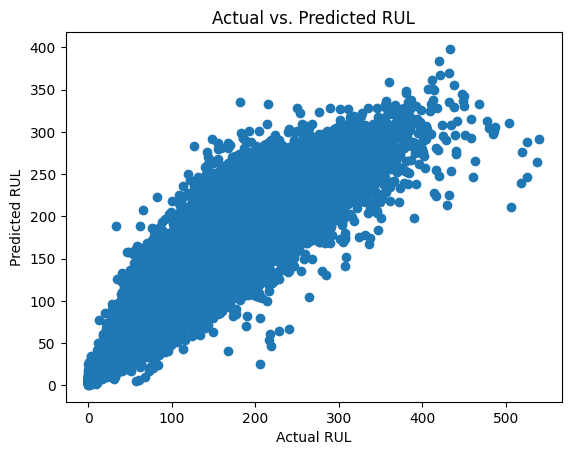

In [16]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL')
plt.show()


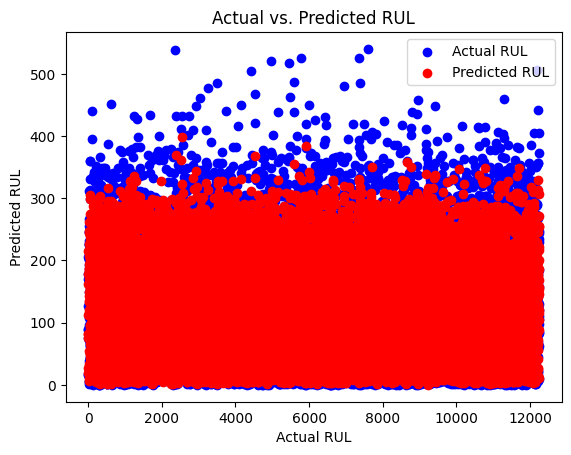

In [17]:
import matplotlib.pyplot as plt

plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual RUL')  # Use range for x-axis (assuming index based)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted RUL')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL')
plt.legend()  # Add legend to differentiate colors
plt.show()

In [20]:
train_splits = [prepare_data(df) for df in train_featured_dfs]

In [29]:
X_train

,unit_number,time_in_cycles,operational_setting_1,operational_setting_2,operational_setting_3,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_22_lag1,sensor_22_lag2,sensor_23_lag1,sensor_23_lag2,sensor_24_lag1,sensor_24_lag2,sensor_25_lag1,sensor_25_lag2,sensor_26_lag1,sensor_26_lag2
11882,48,166,20.0057,0.7000,100.0,491.19,606.64,1473.37,1236.19,9.35,...,306.0,328.0,1915.0,2212.0,84.93,100.0,14.22,10.71,8.5989,6.3072
3998,15,53,0.0005,0.0000,100.0,518.67,642.57,1589.02,1404.54,14.62,...,304.0,334.0,1915.0,2223.0,84.93,100.0,14.25,15.00,8.6647,8.9601
54708,223,147,10.0023,0.2500,100.0,489.05,604.97,1497.76,1305.83,10.52,...,334.0,364.0,2223.0,2324.0,100.00,100.0,14.69,24.49,8.8369,14.7431
25417,104,173,34.9981,0.8417,100.0,449.44,555.03,1362.23,1129.88,5.48,...,308.0,392.0,1915.0,2388.0,84.93,100.0,14.34,39.26,8.7251,23.5143
10993,45,150,19.9990,0.7004,100.0,491.19,608.13,1491.71,1255.05,9.35,...,366.0,334.0,2324.0,2223.0,100.00,100.0,24.32,14.83,14.6624,8.8520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54347,221,262,0.0004,0.0019,100.0,518.67,643.84,1600.34,1419.32,14.62,...,337.0,372.0,2223.0,2319.0,100.00,100.0,15.11,29.14,9.1669,17.4666
38162,157,90,19.9981,0.7008,100.0,491.19,606.66,1466.96,1234.84,9.35,...,390.0,390.0,2388.0,2388.0,100.00,100.0,38.86,38.93,23.3179,23.2719
864,3,245,0.0021,0.0000,100.0,518.67,642.44,1584.00,1404.13,14.62,...,364.0,365.0,2324.0,2324.0,100.00,100.0,24.77,24.86,14.8792,14.7947
15799,62,196,20.0040,0.7000,100.0,491.19,607.27,1488.89,1243.75,9.35,...,334.0,393.0,2223.0,2388.0,100.00,100.0,14.99,39.35,8.9268,23.4257


In [23]:
for X_train, X_test, y_train, y_test in train_splits:

# Create DMatrix for XGBoost training
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters
    params = {
        'objective': 'reg:squarederror',  # Specify the loss function
        'colsample_bytree': 0.3,           # Column subsampling
        'learning_rate': 0.1,               # Step size
        'max_depth': 5,                     # Maximum tree depth
        'alpha': 10,                        # L1 regularization
        'n_estimators': 100                 # Number of boosting rounds
    }

# Train the model
    model = xgb.train(params, dtrain, num_boost_round=100)


d:\Shifted\NASA\venv4\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:14:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Shifted\NASA\venv4\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:14:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Shifted\NASA\venv4\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:14:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
d:\Shifted\NASA\venv4\Lib\site-packages\xgboost\core.py:158: UserWa

In [37]:
for X_train1, X_test1, y_train1, y_test1 in train_splits1:

# Create DMatrix for XGBoost training
    dtrain = xgb.DMatrix(X_train1, label=y_train)
    dtest = xgb.DMatrix(X_test1, label=y_test)

# Set parameters
    params = {
        'objective': 'reg:squarederror',  # Specify the loss function
        'colsample_bytree': 0.3,           # Column subsampling
        'learning_rate': 0.1,               # Step size
        'max_depth': 5,                     # Maximum tree depth
        'alpha': 10,                        # L1 regularization
        'n_estimators': 100                 # Number of boosting rounds
    }

# Train the model
    model1 = xgb.train(params, dtrain, num_boost_round=100)


XGBoostError: [22:29:27] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\data\data.cc:508: Check failed: this->labels.Size() % this->num_row_ == 0 (15994 vs. 0) : Incorrect size for labels.

In [24]:
y_pred = model.predict(dtest)


In [34]:
y_pred1 = model1.predict(dtest)


In [25]:
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)


Mean Squared Error: 1761.9760823458632


In [35]:
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

Mean Squared Error: 1761.9760823458632


In [28]:
import matplotlib.pyplot as plt

# Assuming actual_rul and predicted_rul are your values
plt.figure(figsize=(12, 6))
plt.scatter(actual_rul, predicted_rul, color='blue', label='Predicted vs Actual')
plt.plot([min(actual_rul), max(actual_rul)], [min(actual_rul), max(actual_rul)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'actual_rul' is not defined

<Figure size 1200x600 with 0 Axes>

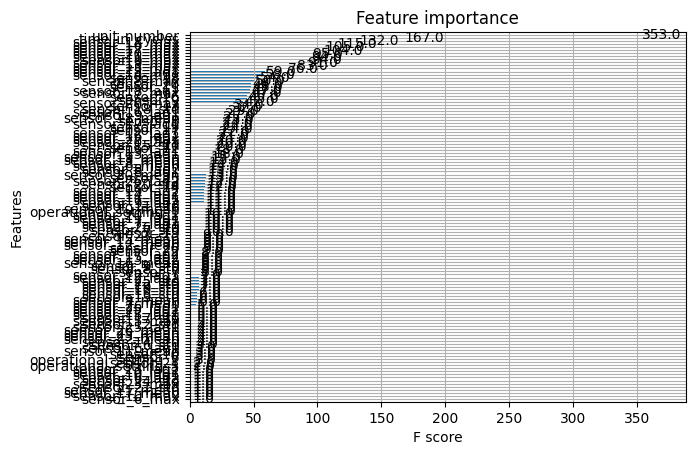

In [27]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()
